**Try to enhance the model**

In [ ]:
import pandas as pd
import os

# Check if the file exists

file_path = "/content/spam.csv"
if os.path.isfile(file_path):
    data = pd.read_csv(file_path, encoding="latin-1")
    print("File content preview:")
    print(data.head())
else:
    print(f"The file '{file_path}' does not exist.")


File content preview:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [ ]:
# Import required libraries
import os
import tarfile
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Define paths for the dataset
SPAM_URL = "https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2"
HAM_URL = "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2"
DATA_DIR = "/content/"
# LOCAL_SMS_SPAM_FILE = "/content/sms_spam.csv"  # Path to manually uploaded SMS Spam dataset
LOCAL_SPAM_CSV_FILE = "/content/spam.csv"  # Path to manually uploaded spam.csv

# Function to download and extract datasets
def download_and_extract(url, extract_to, file_type="tar"):
    file_name = os.path.join(extract_to, url.split("/")[-1])
    if not os.path.exists(file_name):
        print(f"Downloading {file_name}...")
        os.system(f"wget -P {extract_to} {url}")
    if file_type == "tar":
        with tarfile.open(file_name, "r:*") as tar:
            tar.extractall(path=extract_to)
    print(f"Dataset from {url} downloaded and extracted.")

# Function to load emails from a directory
def load_emails_from_directory(directory, label):
    emails = []
    for file_name in os.listdir(directory):
        try:
            with open(os.path.join(directory, file_name), 'r', encoding='latin-1') as file:
                emails.append({'email': file.read(), 'label': label})
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")
    return pd.DataFrame(emails)

# Function to load SMS dataset
def load_sms_dataset(file_path):
    print(f"Loading SMS Spam dataset from {file_path}...")
    messages = pd.read_csv(file_path, header=0, names=['label', 'email'])
    messages['label'] = messages['label'].map({'ham': 0, 'spam': 1})  # Convert labels to binary
    print("SMS Spam dataset loaded successfully.")
    return messages

# Function to load spam.csv dataset
def load_spam_csv_dataset(file_path):
    print(f"Loading spam.csv dataset from {file_path}...")
    dataset = pd.read_csv(file_path, encoding="latin-1")
    dataset = dataset.rename(columns={"v1": "label", "v2": "email"})  # Rename columns
    dataset = dataset[["label", "email"]]  # Keep only relevant columns
    dataset['label'] = dataset['label'].map({'ham': 0, 'spam': 1})  # Map labels to binary
    print("spam.csv dataset loaded successfully.")
    return dataset

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"\W", " ", text)  # Remove non-alphanumeric characters
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.lower()  # Convert to lowercase

# Load SpamAssassin datasets
download_and_extract(SPAM_URL, DATA_DIR, file_type="tar")
download_and_extract(HAM_URL, DATA_DIR, file_type="tar")
spam_path = os.path.join(DATA_DIR, "spam")
ham_path = os.path.join(DATA_DIR, "easy_ham")
spam_data = load_emails_from_directory(spam_path, label=1)
ham_data = load_emails_from_directory(ham_path, label=0)

# Display individual SpamAssassin datasets
print("\n--- SpamAssassin Spam Data ---")
print(spam_data.head())
print(spam_data.count())
print("\n--- SpamAssassin Ham Data ---")
print(ham_data.head())
print(ham_data.count())
# # Load the provided SMS Spam dataset
# if os.path.exists(LOCAL_SMS_SPAM_FILE):
#     sms_data = load_sms_dataset(LOCAL_SMS_SPAM_FILE)
# else:
#     print("SMS Spam dataset not found. Please upload the dataset to the working directory.")
#     sms_data = pd.DataFrame(columns=['label', 'email'])  # Create an empty DataFrame as fallback

# Display SMS Spam dataset
# print("\n--- SMS Spam Data ---")
# print(sms_data.head())

# Load the provided spam.csv dataset
if os.path.exists(LOCAL_SPAM_CSV_FILE):
    spam_csv_data = load_spam_csv_dataset(LOCAL_SPAM_CSV_FILE)
else:
    print("spam.csv dataset not found. Please upload the dataset to the working directory.")
    spam_csv_data = pd.DataFrame(columns=['label', 'email'])  # Create an empty DataFrame as fallback

# Display spam.csv dataset
print("\n--- spam.csv Data ---")
print(spam_csv_data.head())
print(spam_csv_data.count())

# Combine datasets
print("\nCombining datasets...")
data = pd.concat([spam_data, ham_data, spam_csv_data], ignore_index=True)

# Display combined data
print("\n--- Combined Data ---")
print(data.head())
print(data.count())

# Preprocess emails
data['email'] = data['email'].apply(preprocess_text)

# Display preprocessed data
print("\n--- Preprocessed Data ---")
print(data.head())
print(data.count())



# Ensure all labels are valid and integers
print("\n--- Checking Labels Before Processing ---")
print(data['label'].unique())

# Drop rows with invalid or missing labels
data = data.dropna(subset=['label'])  # Remove rows with null labels
data = data[data['label'].isin([0, 1])]  # Keep only rows with valid binary labels

# Convert labels to integers
data['label'] = data['label'].astype(int)

# Debug: Verify unique labels after cleaning
print("\n--- Labels After Cleaning ---")
print(data['label'].unique())

# Prepare the dataset
X = data['email']
y = data['label']

# Debug: Ensure y is binary
print("\n--- Final Label Distribution ---")
print(y.value_counts())

# Preprocess text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', strip_accents='unicode', ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Model Accuracy: {accuracy * 100:.2f}% ---")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Save the model and vectorizer
joblib.dump(model, 'spam_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("\nModel and vectorizer saved successfully.")



Dataset from https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2 downloaded and extracted.
Dataset from https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2 downloaded and extracted.

--- SpamAssassin Spam Data ---
                                               email  label
0  From ilug-admin@linux.ie  Tue Sep 24 15:54:23 ...      1
1  Return-Path: ler@lerami.lerctr.org\nDelivery-D...      1
2  From ilug-admin@linux.ie  Mon Sep 16 10:44:18 ...      1
3  From tammy490t@yahoo.com  Tue Aug 27 05:38:41 ...      1
4  From donaldbae@purplehotel.com  Wed Aug 28 11:...      1
email    501
label    501
dtype: int64

--- SpamAssassin Ham Data ---
                                               email  label
0  From rssfeeds@jmason.org  Thu Oct  3 12:24:54 ...      0
1  From pudge@perl.org  Thu Sep 26 11:02:41 2002\...      0
2  From exmh-users-admin@redhat.com  Fri Sep 13 1...      0
3  From rssfeeds@jmason.org  Thu Sep 26 16:42:08 ...      0
4  From rssfee

In [ ]:
# Save the combined dataset as a CSV file
expanded_dataset_path = "expanded_dataset.csv"
data.to_csv(expanded_dataset_path, index=False)
print(f"Expanded dataset saved as {expanded_dataset_path}.")


Expanded dataset saved as expanded_dataset.csv.


Dataset Preview:
                                               email  label
0  from ilug admin linux ie tue sep 24 15 54 23 2...      1
1  return path ler lerami lerctr org delivery dat...      1
2  from ilug admin linux ie mon sep 16 10 44 18 2...      1
3  from tammy490t yahoo com tue aug 27 05 38 41 2...      1
4  from donaldbae purplehotel com wed aug 28 11 0...      1

Original Class Distribution:
label
0    7326
1    1248
Name: count, dtype: int64

Text Length Distribution Summary:
count      8574.000000
mean       1299.399930
std        4995.635785
min           1.000000
25%          45.000000
50%         121.000000
75%        1989.000000
max      231464.000000
Name: text_length, dtype: float64


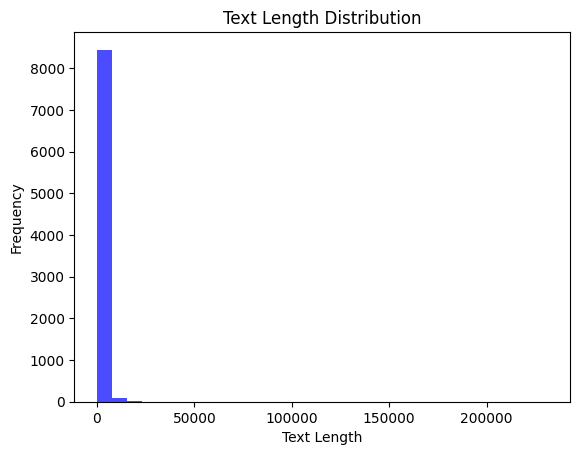


Analyzing most important terms in the dataset...
Top 10 Important Terms by TF-IDF: ['11' '2002' 'com' 'id' 'list' 'localhost' 'net' 'org' 'received'
 'spamassassin']

Applying SMOTE to balance the dataset...

Balanced Class Distribution After SMOTE:
Counter({1: 7326, 0: 7326})

Balanced dataset saved as 'balanced_expanded_dataset.csv'.


In [ ]:
# Advanced Bias Mitigation for Combined Dataset
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter

# Load dataset
file_path = "/content/expanded_dataset.csv"
if os.path.isfile(file_path):
    data = pd.read_csv(file_path)
    print("Dataset Preview:")
    print(data.head())

    # Analyze class distribution
    print("\nOriginal Class Distribution:")
    print(data['label'].value_counts())  # Updated to use 'label' column

    # Analyze text length
    data['text_length'] = data['email'].apply(len)  # Updated to use 'email' column
    print("\nText Length Distribution Summary:")
    print(data['text_length'].describe())

    # Plot text length distribution
    plt.hist(data['text_length'], bins=30, alpha=0.7, color='blue')
    plt.title("Text Length Distribution")
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.show()

    # TF-IDF Analysis
    print("\nAnalyzing most important terms in the dataset...")
    vectorizer = TfidfVectorizer(stop_words="english", max_features=10)
    tfidf_matrix = vectorizer.fit_transform(data['email'])
    important_terms = vectorizer.get_feature_names_out()
    print("Top 10 Important Terms by TF-IDF:", important_terms)

    # Balance dataset using SMOTE
    print("\nApplying SMOTE to balance the dataset...")
    smote = SMOTE(random_state=42)
    features = data['email']
    labels = data['label']  # Updated to use 'label' column

    # Transform text data to numerical form using TF-IDF
    vectorizer = TfidfVectorizer(max_features=500)
    features_vectorized = vectorizer.fit_transform(features).toarray()

    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(features_vectorized, labels)

    # Check new class distribution
    print("\nBalanced Class Distribution After SMOTE:")
    print(Counter(y_resampled))

    # Save the balanced dataset
    balanced_data = pd.DataFrame(X_resampled, columns=vectorizer.get_feature_names_out())
    balanced_data['label'] = y_resampled
    balanced_data.to_csv("/content/balanced_expanded_dataset.csv", index=False)
    print("\nBalanced dataset saved as 'balanced_expanded_dataset.csv'.")
else:
    print(f"The file '{file_path}' does not exist.")


In [ ]:
data2 = pd.read_csv("/content/balanced_expanded_dataset.csv")
print("Expanded Dataset Preview:")
print(data2['label'].value_counts())  # Updated to use 'label' column

Expanded Dataset Preview:
label
1    7326
0    7326
Name: count, dtype: int64


In [ ]:
# Verify the saved dataset
import pandas as pd

df = pd.read_csv("expanded_dataset.csv")
print("Expanded Dataset Preview:")
print(df.head())
print(f"Total Emails in Dataset: {len(df)}")


Expanded Dataset Preview:
                                               email  label
0  from ilug admin linux ie tue sep 24 15 54 23 2...      1
1  return path ler lerami lerctr org delivery dat...      1
2  from ilug admin linux ie mon sep 16 10 44 18 2...      1
3  from tammy490t yahoo com tue aug 27 05 38 41 2...      1
4  from donaldbae purplehotel com wed aug 28 11 0...      1
Total Emails in Dataset: 8574


In [ ]:

# 3. Train Logistic Regression Model and Evaluate Performance

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 97.90%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       1.00      0.87      0.93       266

    accuracy                           0.98      1715
   macro avg       0.99      0.93      0.96      1715
weighted avg       0.98      0.98      0.98      1715



# **Lets go for deployment**

In [ ]:
!pip install flask-ngrok
!pip install pyngrok


In [ ]:
!kill $(lsof -t -i:5000)

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [ ]:
!apt-get install nodejs
!npm install -g localtunnel
!lt --help


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
nodejs is already the newest version (12.22.9~dfsg-1ubuntu3.6).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

changed 22 packages, and audited 23 packages in 4s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
Usage: lt --port [num] <options>

Options:
  -p, --port                Internal HTTP server port                 [required]
  -h, --host                Upstream server providing forwarding
                                             [default: "https://localtunnel.me"]
  -s, --subdomain           Request this subdomain
  -l, --local-host          Tunnel traffic to this host instead of localhost,
                            override Host header to this host
      --local-https         Tunnel traffic to a lo

In [ ]:
!pkill -f ngrok


# **Lets apply more advance model**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import joblib

# Load the dataset
data = pd.read_csv("expanded_dataset.csv")

# Preview the dataset
print("Expanded Dataset Preview:")
print(data.head())

# Rename columns
data.rename(columns={"v1": "label", "v2": "email"}, inplace=True)

# Drop unnecessary columns
data = data[["label", "email"]]
print("\n before mapping Dataset label:")
print(data["label"].head(20),data["email"].head(20) )
# # Map labels to numerical values
# data["label"] = data["label"].map({"ham": 0, "spam": 1})
# print("\n Mapped Dataset label:")
# print(data["label"].head(20))

# Debug: Ensure the mapping is correct
print("\nMapped Dataset Preview:")
print(data.head())

# Separate features and labels
X = data['email']
y = data['label']

# Transform text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', strip_accents='unicode', ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize variables to keep track of the best model
best_model = None
best_accuracy = 0
best_model_name = ""

# Train and save Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic_model.fit(X_train, y_train)
y_pred_log = logistic_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)
print(f"\nLogistic Regression Accuracy: {log_accuracy * 100:.2f}%")
joblib.dump(logistic_model, "logistic_regression.pkl")

if log_accuracy > best_accuracy:
    best_accuracy = log_accuracy
    best_model = logistic_model
    best_model_name = "Logistic Regression"

# Train and save Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
joblib.dump(random_forest_model, "random_forest.pkl")

if rf_accuracy > best_accuracy:
    best_accuracy = rf_accuracy
    best_model = random_forest_model
    best_model_name = "Random Forest"

# Train and save Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier()
gradient_boosting_model.fit(X_train, y_train)
y_pred_gb = gradient_boosting_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {gb_accuracy * 100:.2f}%")
joblib.dump(gradient_boosting_model, "gradient_boosting.pkl")

if gb_accuracy > best_accuracy:
    best_accuracy = gb_accuracy
    best_model = gradient_boosting_model
    best_model_name = "Gradient Boosting"

# Save the best model
joblib.dump(best_model, "best_spam_classifier.pkl")
print(f"\nThe best model is {best_model_name} with an accuracy of {best_accuracy * 100:.2f}%.")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("\nAll models and vectorizer saved successfully.")


Expanded Dataset Preview:
                                               email  label
0  from ilug admin linux ie tue sep 24 15 54 23 2...      1
1  return path ler lerami lerctr org delivery dat...      1
2  from ilug admin linux ie mon sep 16 10 44 18 2...      1
3  from tammy490t yahoo com tue aug 27 05 38 41 2...      1
4  from donaldbae purplehotel com wed aug 28 11 0...      1

 before mapping Dataset label:
0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: label, dtype: int64 0     from ilug admin linux ie tue sep 24 15 54 23 2...
1     return path ler lerami lerctr org delivery dat...
2     from ilug admin linux ie mon sep 16 10 44 18 2...
3     from tammy490t yahoo com tue aug 27 05 38 41 2...
4     from donaldbae purplehotel com wed aug 28 11 0...
5     from akadim yahoo com tue dec 3 11 57 06 2002 ...
6     from apf wu wien ac at thu sep 19 13 01 55 200...
7   

In [ ]:
!pkill -f ngrok


In [ ]:
#Lets apply some more
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# Load and inspect the dataset
data = pd.read_csv("expanded_dataset.csv")
print("Dataset Columns:", data.columns)

# Ensure columns are properly named
if "v1" in data.columns and "v2" in data.columns:
    data.rename(columns={"v1": "label", "v2": "email"}, inplace=True)

# Map 'ham' and 'spam' to binary labels
data["label"] = data["label"].map({"ham": 0, "spam": 1})

# Verify data after preprocessing
print("Processed Dataset Head:")
print(data.head())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["email"], data["label"], test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset format
train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label": y_test})
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df),
})

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

# Save the model and tokenizer
model.save_pretrained("transformer_spam_model")
tokenizer.save_pretrained("transformer_spam_model")
print("Model and tokenizer saved successfully.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6859 [00:00<?, ? examples/s]

Map:   0%|          | 0/1715 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-81-771210d2c166>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.072300,0.042348,0.986589,0.945055,0.969925,0.957328


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.072300,0.042348,0.986589,0.945055,0.969925,0.957328


In [ ]:
import shutil

# Create a zip file of the model folder
shutil.make_archive("/content/transformer_spam_model", 'zip', "/content/transformer_spam_model")


from google.colab import files

# Download the zip file
files.download("/content/transformer_spam_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Next time load the model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Path to the saved model directory
model_path = "transformer_spam_model"  # Adjust this if needed

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

print("Model and tokenizer loaded successfully.")


In [ ]:
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Mount Google Drive
drive.mount('/content/drive')

# Path to the saved model in Google Drive
drive_model_path = "/content/drive/My Drive/transformer_spam_model"  # Update this path if needed

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(drive_model_path)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(drive_model_path)

print("Model and tokenizer loaded successfully.")


Mounted at /content/drive
Model and tokenizer loaded successfully.


In [ ]:
import os
import random
from flask import Flask, request, jsonify, render_template_string
import joblib
import pandas as pd
import threading
from pyngrok import ngrok
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Set your ngrok authentication token
NGROK_AUTH_TOKEN = "2oZlSBbJEDOK9wuWQyq4n3PumWA_6wAwkpDus6zrsfAhi4Dcf"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Feedback file
FEEDBACK_FILE = "feedback_colab.csv"

# Advanced HTML Template for the UI
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Email Spam Detection</title>
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/bootstrap/5.3.0/css/bootstrap.min.css">
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600&display=swap" rel="stylesheet">
    <style>
        body {
            font-family: 'Poppins', sans-serif;
            background: linear-gradient(135deg, #1e3c72, #2a5298);
            color: #fff;
            min-height: 100vh;
            margin: 0;
            display: flex;
            justify-content: center;
            align-items: center;
        }
        .container {
            background-color: rgba(255, 255, 255, 0.1);
            border-radius: 15px;
            padding: 30px;
            max-width: 700px;
            box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
            backdrop-filter: blur(10px);
            -webkit-backdrop-filter: blur(10px);
        }
        h1 {
            font-weight: 600;
            font-size: 2rem;
            text-align: center;
        }
        textarea {
            width: 100%;
            height: 150px;
            margin-bottom: 20px;
            border: none;
            border-radius: 10px;
            padding: 15px;
            background-color: #f8f9fa;
            font-size: 1rem;
        }
        select, button {
            width: 100%;
            padding: 10px;
            font-size: 1rem;
            border-radius: 10px;
            margin-top: 10px;
        }
        button {
            background: linear-gradient(135deg, #f7971e, #ffd200);
            border: none;
            color: #333;
            font-weight: bold;
        }
        button:hover {
            background: linear-gradient(135deg, #ffd200, #f7971e);
            color: #000;
        }
        .result, .feedback {
            margin-top: 20px;
            text-align: center;
            padding: 10px;
            border-radius: 10px;
            background: rgba(255, 255, 255, 0.2);
        }
        .result p {
            font-size: 1.2rem;
        }
        .feedback button {
            margin: 5px;
            background-color: #007bff;
            color: #fff;
            border: none;
            padding: 10px 15px;
            border-radius: 5px;
        }
        .feedback button:hover {
            background-color: #0056b3;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Email Spam Detection</h1>
        <form id="email-form">
            <textarea id="email" placeholder="Paste your email content here..." required></textarea>
            <select id="model">
                <option value="Best Model">Best Model</option>
                <option value="Logistic Regression">Logistic Regression</option>
                <option value="Random Forest">Random Forest</option>
                <option value="Gradient Boosting">Gradient Boosting</option>
            </select>
            <button type="submit">Detect</button>
        </form>
        <div class="result" id="result"></div>
        <div class="feedback" id="feedback"></div>
    </div>

    <script>
        document.getElementById('email-form').addEventListener('submit', async (e) => {
            e.preventDefault();
            const email = document.getElementById('email').value;
            const model = document.getElementById('model').value;

            document.getElementById('result').innerHTML = "Processing...";
            document.getElementById('feedback').innerHTML = "";

            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify({ email, model }),
                });
                const data = await response.json();

                if (response.ok) {
                    document.getElementById('result').innerHTML = `
                        <p><strong>Prediction:</strong> ${data.prediction}</p>

                        <p>Was this prediction correct?</p>
                        <div class="d-flex justify-content-center">
                            <button id="yes-button">Yes</button>
                            <button id="no-button">No</button>
                        </div>
                    `;

                    document.getElementById('yes-button').addEventListener('click', () => submitFeedback(email, data.prediction, 1));
                    document.getElementById('no-button').addEventListener('click', () => submitFeedback(email, data.prediction, 0));
                } else {
                    document.getElementById('result').innerText = data.error;
                }
            } catch (err) {
                document.getElementById('result').innerText = "An error occurred. Please try again.";
            }
        });

        async function submitFeedback(email, predicted, actual) {
            try {
                const response = await fetch('/feedback', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify({ email, predicted_label: predicted, actual_label: actual }),
                });
                const data = await response.json();
                document.getElementById('feedback').innerText = data.message;
            } catch (err) {
                document.getElementById('feedback').innerText = "An error occurred while submitting feedback.";
            }
        }
    </script>
</body>
</html>
"""


# Initialize Flask app
app = Flask(__name__)

@app.route("/")
def home():
    return render_template_string(HTML_TEMPLATE)

@app.route("/predict", methods=["POST"])
def predict():
    email = request.json.get("email", "")
    model_name = request.json.get("model", "Best Model")

    if not email:
        return jsonify({"error": "Email content is empty"}), 400

    try:
        vectorizer = joblib.load("tfidf_vectorizer.pkl")
    except FileNotFoundError:
        return jsonify({"error": "TF-IDF vectorizer file not found."}), 500

    try:
        if model_name == "Logistic Regression":
            model = joblib.load("logistic_regression.pkl")
        elif model_name == "Random Forest":
            model = joblib.load("random_forest.pkl")
        elif model_name == "Gradient Boosting":
            model = joblib.load("gradient_boosting.pkl")
        else:
            model = joblib.load("best_spam_classifier.pkl")
    except FileNotFoundError:
        return jsonify({"error": f"Model file for {model_name} not found."}), 500

    try:
        email_vector = vectorizer.transform([email])
        prediction = model.predict(email_vector)[0]
        result = "Spam" if prediction == 1 else "Ham"
        return jsonify({"prediction": result})
    except Exception as e:
        return jsonify({"error": f"Error during prediction: {str(e)}"}), 500

@app.route("/feedback", methods=["POST"])
def feedback():
    email = request.json.get("email", "")
    predicted_label = request.json.get("predicted_label", -1)
    actual_label = request.json.get("actual_label", -1)

    if not email or predicted_label == -1 or actual_label == -1:
        return jsonify({"error": "Invalid feedback data"}), 400

    feedback_data = pd.DataFrame([{
        "email": email,
        "predicted_label": predicted_label,
        "actual_label": actual_label
    }])
    feedback_data.to_csv(FEEDBACK_FILE, mode="a", header=not os.path.exists(FEEDBACK_FILE), index=False)

    feedback_count = len(pd.read_csv(FEEDBACK_FILE))
    if feedback_count >= 100:
        retrain_model()

    return jsonify({"message": "Feedback submitted successfully"})

def retrain_model():
    print("\nRetraining the model with feedback data...")
    feedback_data = pd.read_csv(FEEDBACK_FILE)
    X = feedback_data['email']
    y = feedback_data['actual_label']

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2))
    X_tfidf = vectorizer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    joblib.dump(model, "best_spam_classifier.pkl")
    print("\nModel retrained and updated successfully.")

def start_server_and_tunnel():
    dynamic_port = random.randint(8000, 9000)
    threading.Thread(target=lambda: app.run(port=dynamic_port)).start()
    public_url = ngrok.connect(dynamic_port).public_url
    print(f"Access the app at: {public_url}")

start_server_and_tunnel()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8288
INFO:werkzeug:Press CTRL+C to quit


Access the app at: https://66eb-104-199-136-195.ngrok-free.app


In [ ]:
!pkill -f ngrok

In [ ]:
#Advance UI

import os
import random
from flask import Flask, request, jsonify, render_template_string
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import threading
from pyngrok import ngrok
import joblib

# Set your ngrok authentication token
NGROK_AUTH_TOKEN = "2oZlSBbJEDOK9wuWQyq4n3PumWA_6wAwkpDus6zrsfAhi4Dcf"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Feedback file
FEEDBACK_FILE = "feedback_colab.csv"

# Enhanced HTML Template for the UI
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Email Spam Detection</title>
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/bootstrap/5.3.0/css/bootstrap.min.css">
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600&display=swap" rel="stylesheet">
    <style>
        body {
            font-family: 'Poppins', sans-serif;
            background: linear-gradient(135deg, #1e3c72, #2a5298);
            color: #fff;
            min-height: 100vh;
            margin: 0;
            display: flex;
            justify-content: center;
            align-items: center;
        }
        .container {
            background-color: rgba(255, 255, 255, 0.1);
            border-radius: 15px;
            padding: 30px;
            max-width: 700px;
            box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
            backdrop-filter: blur(10px);
            -webkit-backdrop-filter: blur(10px);
        }
        h1 {
            font-weight: 600;
            font-size: 2rem;
            text-align: center;
        }
        textarea {
            width: 100%;
            height: 150px;
            margin-bottom: 20px;
            border: none;
            border-radius: 10px;
            padding: 15px;
            background-color: #f8f9fa;
            font-size: 1rem;
        }
        select, button {
            width: 100%;
            padding: 10px;
            font-size: 1rem;
            border-radius: 10px;
            margin-top: 10px;
        }
        button {
            background: linear-gradient(135deg, #f7971e, #ffd200);
            border: none;
            color: #333;
            font-weight: bold;
        }
        button:hover {
            background: linear-gradient(135deg, #ffd200, #f7971e);
            color: #000;
        }
        .result, .feedback {
            margin-top: 20px;
            text-align: center;
            padding: 10px;
            border-radius: 10px;
            background: rgba(255, 255, 255, 0.2);
        }
        .result p {
            font-size: 1.2rem;
        }
        .feedback button {
            margin: 5px;
            background-color: #007bff;
            color: #fff;
            border: none;
            padding: 10px 15px;
            border-radius: 5px;
        }
        .feedback button:hover {
            background-color: #0056b3;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Email Spam Detection</h1>
        <form id="email-form">
            <textarea id="email" placeholder="Paste your email content here..." required></textarea>
            <select id="model">
                <option value="Transformer">Transformer (DistilBERT)</option>
                <option value="Logistic Regression">Logistic Regression</option>
                <option value="Random Forest">Random Forest</option>
                <option value="Gradient Boosting">Gradient Boosting</option>
            </select>
            <button type="submit">Detect</button>
        </form>
        <div class="result" id="result"></div>
        <div class="feedback" id="feedback"></div>
    </div>

    <script>
        document.getElementById('email-form').addEventListener('submit', async (e) => {
            e.preventDefault();
            const email = document.getElementById('email').value;
            const model = document.getElementById('model').value;

            document.getElementById('result').innerHTML = "Processing...";
            document.getElementById('feedback').innerHTML = "";

            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify({ email, model }),
                });
                const data = await response.json();

                if (response.ok) {
                    document.getElementById('result').innerHTML = `
                        <p><strong>Prediction:</strong> ${data.prediction}</p>
                        <p>Was this prediction correct?</p>
                        <div class="d-flex justify-content-center">
                            <button id="yes-button">Yes</button>
                            <button id="no-button">No</button>
                        </div>
                    `;

                    document.getElementById('yes-button').addEventListener('click', () => submitFeedback(email, data.prediction, 1));
                    document.getElementById('no-button').addEventListener('click', () => submitFeedback(email, data.prediction, 0));
                } else {
                    document.getElementById('result').innerText = data.error;
                }
            } catch (err) {
                document.getElementById('result').innerText = "An error occurred. Please try again.";
            }
        });

        async function submitFeedback(email, predicted, actual) {
            try {
                const response = await fetch('/feedback', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify({ email, predicted_label: predicted, actual_label: actual }),
                });
                const data = await response.json();
                document.getElementById('feedback').innerText = data.message;
            } catch (err) {
                document.getElementById('feedback').innerText = "An error occurred while submitting feedback.";
            }
        }
    </script>
</body>
</html>
"""

# Initialize Flask app
app = Flask(__name__)

# Load the Hugging Face Transformer model and tokenizer
# transformer_model_path = "/content/transformer_spam_model"  # Update path if needed
# tokenizer = AutoTokenizer.from_pretrained(transformer_model_path)
# transformer_model = AutoModelForSequenceClassification.from_pretrained(transformer_model_path)

from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Mount Google Drive
drive.mount('/content/drive')

# Path to the saved model in Google Drive
drive_model_path = "/content/drive/My Drive/transformer_spam_model"  # Update this path if needed

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(drive_model_path)

# Load the model
transformer_model = AutoModelForSequenceClassification.from_pretrained(drive_model_path)

print("Model and tokenizer loaded successfully.")

# tokenizer = AutoTokenizer.from_pretrained(transformer_model_path)
# transformer_model = AutoModelForSequenceClassification.from_pretrained(transformer_model_path)

@app.route("/")
def home():
    return render_template_string(HTML_TEMPLATE)

@app.route("/predict", methods=["POST"])
def predict():
    email = request.json.get("email", "")
    model_name = request.json.get("model", "Transformer")

    if not email:
        return jsonify({"error": "Email content is empty"}), 400

    try:
        if model_name == "Transformer":
            inputs = tokenizer(email, return_tensors="pt", truncation=True, padding=True)
            outputs = transformer_model(**inputs)
            prediction = outputs.logits.argmax(-1).item()
            result = "Spam" if prediction == 1 else "Ham"
        elif model_name == "Logistic Regression":
            vectorizer = joblib.load("tfidf_vectorizer.pkl")
            model = joblib.load("logistic_regression.pkl")
            email_vector = vectorizer.transform([email])
            prediction = model.predict(email_vector)[0]
            result = "Spam" if prediction == 1 else "Ham"
        elif model_name == "Random Forest":
            vectorizer = joblib.load("tfidf_vectorizer.pkl")
            model = joblib.load("random_forest.pkl")
            email_vector = vectorizer.transform([email])
            prediction = model.predict(email_vector)[0]
            result = "Spam" if prediction == 1 else "Ham"
        elif model_name == "Gradient Boosting":
            vectorizer = joblib.load("tfidf_vectorizer.pkl")
            model = joblib.load("gradient_boosting.pkl")
            email_vector = vectorizer.transform([email])
            prediction = model.predict(email_vector)[0]
            result = "Spam" if prediction == 1 else "Ham"
        else:
            return jsonify({"error": "Model not recognized"}), 400

        return jsonify({"prediction": result})
    except Exception as e:
        return jsonify({"error": f"Error during prediction: {str(e)}"}), 500

@app.route("/feedback", methods=["POST"])
def feedback():
    try:
        email = request.json.get("email", "")
        predicted_label = request.json.get("predicted_label", -1)
        actual_label = request.json.get("actual_label", -1)

        # Validate feedback data
        if not email or predicted_label == -1 or actual_label == -1:
            return jsonify({"error": "Invalid feedback data"}), 400

        # Log feedback for debugging
        print("Received Feedback Data:")
        print(f"Email: {email}")
        print(f"Predicted Label: {predicted_label}")
        print(f"Actual Label: {actual_label}")

        # Save feedback to CSV
        feedback_data = pd.DataFrame([{
            "email": email,
            "predicted_label": predicted_label,
            "actual_label": actual_label
        }])
        feedback_data.to_csv(FEEDBACK_FILE, mode="a", header=not os.path.exists(FEEDBACK_FILE), index=False)

        # Check feedback count and retrain if needed
        feedback_count = len(pd.read_csv(FEEDBACK_FILE))
        print(f"Feedback count: {feedback_count}")
        if feedback_count >= 100:
            retrain_model()

        return jsonify({"message": "Feedback submitted successfully"})
    except Exception as e:
        print(f"Error in feedback endpoint: {str(e)}")
        return jsonify({"error": f"Error during feedback processing: {str(e)}"}), 500

def retrain_model():
    print("\nRetraining the model with feedback data...")
    feedback_data = pd.read_csv(FEEDBACK_FILE)
    X = feedback_data['email']
    y = feedback_data['actual_label']

    # Perform retraining for one of the models (e.g., Logistic Regression)
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2))
    X_tfidf = vectorizer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    # Save the retrained model
    joblib.dump(model, "best_spam_classifier.pkl")
    print("\nModel retrained and updated successfully.")

def start_server_and_tunnel():
    dynamic_port = random.randint(8000, 9000)
    threading.Thread(target=lambda: app.run(port=dynamic_port)).start()
    public_url = ngrok.connect(dynamic_port).public_url
    print(f"Access the app at: {public_url}")

# Start the server
start_server_and_tunnel()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer loaded successfully.
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8807
INFO:werkzeug:Press CTRL+C to quit


Access the app at: https://6629-104-199-136-195.ngrok-free.app


In [ ]:
!pip install markdown


In [ ]:
#Advance UI

import os
import random
from flask import Flask, request, jsonify, render_template_string
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import threading
from pyngrok import ngrok
import joblib

# Set your ngrok authentication token
NGROK_AUTH_TOKEN = "2oZlSBbJEDOK9wuWQyq4n3PumWA_6wAwkpDus6zrsfAhi4Dcf"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Feedback file
FEEDBACK_FILE = "feedback_colab.csv"

# Enhanced HTML Template for the UI
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Email Spam Detection</title>
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/bootstrap/5.3.0/css/bootstrap.min.css">
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600&display=swap" rel="stylesheet">
    <style>
        body {
            font-family: 'Poppins', sans-serif;
            background: linear-gradient(135deg, #1e3c72, #2a5298);
            color: #fff;
            min-height: 100vh;
            margin: 0;
            display: flex;
            justify-content: center;
            align-items: center;
            padding: 20px;
        }
        .container {
            background-color: rgba(255, 255, 255, 0.15);
            border-radius: 15px;
            padding: 30px;
            max-width: 800px;
            width: 100%;
            box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
            backdrop-filter: blur(10px);
            -webkit-backdrop-filter: blur(10px);
        }
        h1 {
            font-weight: 700;
            font-size: 2.5rem;
            text-align: center;
        }
        textarea {
            width: 100%;
            height: 150px;
            margin-bottom: 20px;
            border: none;
            border-radius: 10px;
            padding: 15px;
            background-color: #f8f9fa;
            font-size: 1rem;
            resize: none;
        }
        select, button {
            width: 100%;
            padding: 12px;
            font-size: 1rem;
            border-radius: 10px;
            margin-top: 10px;
            border: none;
        }
        button {
            background: linear-gradient(135deg, #ff7e5f, #feb47b);
            color: #fff;
            font-weight: bold;
            transition: all 0.3s ease-in-out;
        }
        button:hover {
            background: linear-gradient(135deg, #feb47b, #ff7e5f);
            transform: scale(1.05);
        }
        .result, .feedback {
            margin-top: 20px;
            text-align: center;
            padding: 15px;
            border-radius: 10px;
            background: rgba(255, 255, 255, 0.2);
        }
        .result p, .feedback p {
            font-size: 1.2rem;
        }
        .feedback button {
            margin: 5px;
            background-color: #007bff;
            color: #fff;
            padding: 10px 15px;
            border-radius: 5px;
            border: none;
            transition: all 0.3s ease-in-out;
        }
        .feedback button:hover {
            background-color: #0056b3;
            transform: scale(1.1);
        }
        #confidence-chart, #metrics-chart {
            margin-top: 20px;
        }
        @media (max-width: 768px) {
            h1 {
                font-size: 2rem;
            }
            textarea {
                height: 120px;
            }
            .container {
                padding: 20px;
            }
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Email Spam Detection</h1>
        <form id="email-form">
            <textarea id="email" placeholder="Paste your email content here..." required></textarea>
            <select id="model">
                <option value="Transformer">Transformer (DistilBERT)</option>
                <option value="Logistic Regression">Logistic Regression</option>
                <option value="Random Forest">Random Forest</option>
                <option value="Gradient Boosting">Gradient Boosting</option>
            </select>
            <button type="submit">Detect</button>
        </form>
        <div id="result-container">
            <div class="result" id="result"></div>
            <canvas id="confidence-chart" style="max-width: 100%; margin: 20px auto;"></canvas>
            <div id="performance-metrics">
                <h3 class="text-center">Confidence Metrics</h3>
                <canvas id="metrics-chart" style="max-width: 100%; margin: 0 auto;"></canvas>
            </div>
        </div>
        <div class="feedback" id="feedback"></div>
    </div>
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    <script>
        document.getElementById('email-form').addEventListener('submit', async (e) => {
            e.preventDefault();
            const email = document.getElementById('email').value;
            const model = document.getElementById('model').value;

            document.getElementById('result').innerHTML = "Processing...";
            document.getElementById('feedback').innerHTML = "";

            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify({ email, model }),
                });
                const data = await response.json();

                if (response.ok) {
                    document.getElementById('result').innerHTML = `
                        <p><strong>Prediction:</strong> ${data.prediction}</p>
                        <p>Was this prediction correct?</p>
                        <div class="d-flex justify-content-center">
                            <button id="yes-button" class="feedback-button">Yes</button>
                            <button id="no-button" class="feedback-button">No</button>
                        </div>
                    `;
                    const confidenceCtx = document.getElementById('confidence-chart').getContext('2d');
                    new Chart(confidenceCtx, {
                        type: 'bar',
                        data: {
                            labels: ['Spam', 'Ham'],
                            datasets: [{
                                label: 'Confidence Score (%)',
                                data: [data.confidence[1] * 100, data.confidence[0] * 100],
                                backgroundColor: ['#ff6384', '#36a2eb'],
                            }]
                        },
                        options: { responsive: true },
                    });

                    document.getElementById('yes-button').addEventListener('click', () => submitFeedback(email, data.prediction, 1));
                    document.getElementById('no-button').addEventListener('click', () => submitFeedback(email, data.prediction, 0));
                } else {
                    document.getElementById('result').innerText = data.error || "An error occurred. Please try again.";
                }
            } catch (err) {
                document.getElementById('result').innerText = "An error occurred. Please try again.";
            }
        });

        async function submitFeedback(email, predicted, actual) {
            try {
                const response = await fetch('/feedback', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify({ email, predicted_label: predicted, actual_label: actual }),
                });
                const data = await response.json();
                document.getElementById('feedback').innerText = data.message;
            } catch (err) {
                document.getElementById('feedback').innerText = "An error occurred while submitting feedback.";
            }
        }
    </script>
</body>
</html>

"""


# Initialize Flask app
app = Flask(__name__)

# Load the Hugging Face Transformer model and tokenizer
# transformer_model_path = "/content/transformer_spam_model"  # Update path if needed
# tokenizer = AutoTokenizer.from_pretrained(transformer_model_path)
# transformer_model = AutoModelForSequenceClassification.from_pretrained(transformer_model_path)

from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Mount Google Drive
drive.mount('/content/drive')

# Path to the saved model in Google Drive
drive_model_path = "/content/drive/My Drive/transformer_spam_model"  # Update this path if needed

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(drive_model_path)

# Load the model
transformer_model = AutoModelForSequenceClassification.from_pretrained(drive_model_path)

print("Model and tokenizer loaded successfully.")

# tokenizer = AutoTokenizer.from_pretrained(transformer_model_path)
# transformer_model = AutoModelForSequenceClassification.from_pretrained(transformer_model_path)

@app.route("/")
def home():
    return render_template_string(HTML_TEMPLATE)

@app.route("/predict", methods=["POST"])
def predict():
    email = request.json.get("email", "")
    model_name = request.json.get("model", "Transformer")

    if not email:
        return jsonify({"error": "Email content is empty"}), 400

    try:
        # Load vectorizer and models
        vectorizer_path = "/content/tfidf_vectorizer.pkl"
        logistic_model_path = "/content/logistic_regression.pkl"
        random_forest_model_path = "/content/random_forest.pkl"
        gradient_boosting_model_path = "/content/gradient_boosting.pkl"

        vectorizer = joblib.load(vectorizer_path)

        if model_name == "Transformer":
            # Transformer model prediction
            inputs = tokenizer(email, return_tensors="pt", truncation=True, padding=True)
            outputs = transformer_model(**inputs)
            logits = outputs.logits
            probabilities = logits.softmax(dim=-1).tolist()[0]
            prediction = int(np.argmax(probabilities))
            result = "Spam" if prediction == 1 else "Ham"

        elif model_name == "Logistic Regression":
            # Logistic Regression model prediction
            logistic_model = joblib.load(logistic_model_path)
            email_vector = vectorizer.transform([email])
            probabilities = logistic_model.predict_proba(email_vector)[0]
            prediction = int(np.argmax(probabilities))
            result = "Spam" if prediction == 1 else "Ham"

        elif model_name == "Random Forest":
            # Random Forest model prediction
            random_forest_model = joblib.load(random_forest_model_path)
            email_vector = vectorizer.transform([email])
            probabilities = random_forest_model.predict_proba(email_vector)[0]
            prediction = int(np.argmax(probabilities))
            result = "Spam" if prediction == 1 else "Ham"

        elif model_name == "Gradient Boosting":
            # Gradient Boosting model prediction
            gradient_boosting_model = joblib.load(gradient_boosting_model_path)
            email_vector = vectorizer.transform([email])
            probabilities = gradient_boosting_model.predict_proba(email_vector)[0]
            prediction = int(np.argmax(probabilities))
            result = "Spam" if prediction == 1 else "Ham"

        else:
            return jsonify({"error": "Model not recognized"}), 400

        # Return the prediction and confidence scores
        return jsonify({
            "prediction": result,
            "confidence": [round(probabilities[0] * 100, 2), round(probabilities[1] * 100, 2)],
        })

    except FileNotFoundError as e:
        return jsonify({"error": f"File not found: {str(e)}"}), 500
    except Exception as e:
        return jsonify({"error": f"Error during prediction: {str(e)}"}), 500




@app.route("/feedback", methods=["POST"])
def feedback():
    try:
        email = request.json.get("email", "")
        predicted_label = request.json.get("predicted_label", -1)
        actual_label = request.json.get("actual_label", -1)

        # Validate feedback data
        if not email or predicted_label == -1 or actual_label == -1:
            return jsonify({"error": "Invalid feedback data"}), 400

        # Log feedback for debugging
        print("Received Feedback Data:")
        print(f"Email: {email}")
        print(f"Predicted Label: {predicted_label}")
        print(f"Actual Label: {actual_label}")

        # Save feedback to CSV
        feedback_data = pd.DataFrame([{
            "email": email,
            "predicted_label": predicted_label,
            "actual_label": actual_label
        }])
        feedback_data.to_csv(FEEDBACK_FILE, mode="a", header=not os.path.exists(FEEDBACK_FILE), index=False)

        # Check feedback count and retrain if needed
        feedback_count = len(pd.read_csv(FEEDBACK_FILE))
        print(f"Feedback count: {feedback_count}")
        if feedback_count >= 100:
            retrain_model()

        return jsonify({"message": "Feedback submitted successfully"})
    except Exception as e:
        print(f"Error in feedback endpoint: {str(e)}")
        return jsonify({"error": f"Error during feedback processing: {str(e)}"}), 500

def retrain_model():
    print("\nRetraining the model with feedback data...")
    feedback_data = pd.read_csv(FEEDBACK_FILE)
    X = feedback_data['email']
    y = feedback_data['actual_label']

    # Perform retraining for one of the models (e.g., Logistic Regression)
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2))
    X_tfidf = vectorizer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    # Save the retrained model
    joblib.dump(model, "best_spam_classifier.pkl")
    print("\nModel retrained and updated successfully.")

def start_server_and_tunnel():
    dynamic_port = random.randint(8000, 9000)
    threading.Thread(target=lambda: app.run(port=dynamic_port)).start()
    public_url = ngrok.connect(dynamic_port).public_url
    print(f"Access the app at: {public_url}")

# Start the server
start_server_and_tunnel()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer loaded successfully.
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8039
INFO:werkzeug:Press CTRL+C to quit


Access the app at: https://1b7d-104-199-136-195.ngrok-free.app


In [ ]:
!pkill -f ngrok